[In my previous post](simulating-inline-holograms.html), I described a method for simulating inline holography images. The ultimate purpose of doing this was to generate holography data that could be used to test the performance of different reconstruction algorithms. Since I would know the input object, I could apply the reconstruction algorithm to the holograms and see how closely the reconstructed object matched the known input.

My modeling however ignored an important aspect about the holographic process, namely the acquisition of digital images and the assoicated noise that would accompany the raw data. This is important because holographic reconstruction algorithms need to be robust against the uncertainty that will inevitably be introduced by recording the hologram with a digital camera.

In [1]:
%pylab inline
import scipy
from numpy.fft import fft2, fftshift, ifftshift
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#272b30'
plt.rcParams['image.cmap'] = 'viridis' 

print('Python version:\n{}\n'.format(sys.version))
print('Numpy version:\t\t{}'.format(np.__version__))
print('matplotlib version:\t{}'.format(matplotlib.__version__))
print('Scipy version:\t\t{}'.format(scipy.__version__))

Populating the interactive namespace from numpy and matplotlib
Python version:
3.7.0 (default, Aug 17 2018, 19:20:07) 
[GCC 5.4.0 20160609]

Numpy version:		1.16.1
matplotlib version:	3.0.2
Scipy version:		1.2.1


# A Mathematical Model for Camera Noise

One of the best descriptions of camera noise that I have ever found may be the [EMVA 1288 Standard](http://www.emva.org/standards-technology/emva-1288/). This document details a standard set of models and procedures to characterize CMOS and CCD cameras and light sensors. From its website:

> EMVA launched the initiative to define a unified method to measure, compute and present specification parameters for cameras and image sensors used for machine vision applications... [The EMVA Standard] creates transparency by defining reliable and exact measurement procedures as well as data presentation guidelines and makes the comparison of cameras and image sensors much easier.

In particular, chapters 2 and 3 of the Standard provide a very clear and concise description the mathematical model for CCD/CMOS camera noise. Below, I have adapted the image of the mathematical model presented at the beginning of chapter 2.

![Optical system with pupils](/images/camera_noise_model.png)

In this model, the camera/sensor is a single pixel that takes an input (a number of photons) and transforms this number to an output (a digital value in analog-to-digital units, or ADU). In performing this transformation, various sources of noise are added to the signal so that, given a camera's output in ADU, we can only make probabilisitic inferences about the actual number of photons impinging upon it. There are also a few assumptions in this model that, when taken together, constitute what's called an *ideal image sensor*. They are:

1. the numer of photons collected by the pixel depends on the product of irradiance \\( E \, \left[ W / m^2 \right] \\) and the exposure time \\( t_{exp} \, \left[ s \right] \\);
2. the sensor is linear, i.e. the digital signal \\( y \\) increases linearly with the number of photons received;
3. all noise sources are constant in time and space;
4. only the total quantum efficiency of the camera is dependent on the wavelength of the incident irradiation;
5. and only the dark current depends on the temperature.

From these five assumptions, the laws of quantum mechanics, and the laws of probability, expressions for the mean output, \\( \mu_y \\), the variance of the output \\( \sigma_y^2 \\), and the signal-to-noise ratio (\\(SNR \\)) may be derived.

\begin{equation*}
\mu_y = K \mu_d + K \eta \mu_p \\
\sigma_y^2 = K^2 \sigma_d^2 + K \left( \mu_y - K \mu_d \right) \\
SNR = \frac{\eta \mu_p}{\sqrt{\sigma_d^2 + \sigma_q^2/K^2 + \eta \mu_p}}
\end{equation*}

In these expressions, \\(\mu\\) and \\(\sigma^2\\) represent the mean and variance of the number of photons hitting the camera (\\(p\\)), the dark noise (\\(d\\)), and the output signal in ADU's (\\(y\\)). The number of electrons \\( \mu_e \\) generated by \\(\mu_p\\) photons hitting the active area of the sensor is obtained from the expression for the quantum efficiency \\(\eta\\), an engineered property of the camera that in general depends on the wavelength.

\begin{equation*}
\eta \left( \lambda \right) = \frac{\mu_e}{\mu_p}
\end{equation*}

The sensitivity of the camera \\(K \, \left[ ADU / e^- \right] \\) represents the amplification of the voltage in the pixel from the photoelectrons and is also a property of the camera. Finally, \\( \sigma_q^2 \\) represents the noise introduced by digitzing the continous voltage signal into a digital one.

The EMVA 1288 Standard explains how to derive these expressions from the assumptions and known physical laws, so I will not go into their derivations in this post. Instead, I will focus on explaining how we can use this model to simulate the effects of camera noise in our holograms.

# From Model to Simulation

The goal of the simulation will be to take a simulated hologram as input and convert it into an image that might be captured by a digital camera. This means that the final image should contain noise that is realistic and follows the rules of the model.

The model will depend on five free parameters that vary from camera-to-camera. They are:

1. the total quantum efficiency \\( \eta \\);
2. the read noise variance \\( \sigma_{r}^2 \\) (or its standard deviation);
3. the dark current \\( \mu_I \\);
4. the sensitivity \\(K\\);
5. and the bit-depth of the camera \\(k\\).

The dark noise \\( \sigma_d^2 \\) is actually comprised of two separate noise sources, i.e. the read noise \\( \sigma_r^2 \\) and the dark current \\( \mu_I \\). Because the noise sources are independent, we can write

\begin{equation*}
\sigma_d^2 = \sigma_r^2 + \sigma_I^2 \\
\sigma_d^2 = \sigma_r^2 + \mu_I t_{exp}
\end{equation*}

where the last step relies on the fact that the generation of thermal electrons is a Poisson process whose mean is equal to its variance. The units of \\(\mu_I\\) are \\(e^- / s \\) and values for \\( \mu_I \\) are often provided on camera spec. sheets. Likewise, the read noise \\(\sigma_r^2\\) is also provided on spec. sheets, although in my experience the units are likely to be in root-mean-square electrons or median electrons and not electrons-squared.

Other than the inputs, we do not need to provide values for the other numbers in the model because they are related to the free parameters by various physical and mathematical laws.

Finally, let's ignore spatial noise sources in these simulations because it's difficult to characterize them with a single number. Spatial noise is a variation in the free parameters of the camera from pixel to pixel. An example of a common type of spatial noise is photon response non-uniformity and is manifest in a sensitivity \\( K \\) that varies between pixels. Ignoring spatial noise in the simulations simply means that values for the read noise, dark current, quantum efficiency, and sensitivty are the same for all pixels.

## Step 0: Convert the electric field to photons

Before doing anything, we need to take the electric field from our Fourier optics simulations and convert it to units of photons. If it isn't clear how you would first get an electric field, you can refer to my [previous post](simulating-inline-holograms.html) on calculating the hologram of a thin, circular phase-only object. Typically, the calcuation of the electric field will follow from the laws of diffraction and serve as an input for the camera model.

To get the number of photons, we first compute the irradiance of the field using the magnitude of the time-averaged [Poynting vector](https://en.wikipedia.org/wiki/Poynting_vector#Plane_waves) of a linearly-polarzed electromagnetic wave in free space, which is

\begin{equation*}
E \left(x, y \right) = \frac{1}{2Z_o} \left| U\left(x, y \right) \right|^2
\end{equation*}

Here, \\(E \left( x, y \right) \\) is the irradiance at point \\( \left( x, y \right) \\), \\(U \left( x, y \right) \\) is the scalar electric field at the same point, and \\(Z_0 = 377 \, \Omega \\) is the [impedance of free space](https://en.wikipedia.org/wiki/Wave_impedance). We would change the value for the impedance if we were imaging in a medium other than vacuum. The units of the field are \\( V / m \\) which, when squared and divided by the units of the impedance (Ohms), gives units of power per area, or \\( W / m^2 \\). It's also worth mentioning that we are implicitly assuming the field varies smoothly on the length scale of a pixel. This is why we can use the expression for the Poynting vector of a plane wave.

The mean number of photons is obtained from the irradiance by the expression

\begin{align*}
\mu_p &= \frac{\lambda A}{hc}Et_{exp} \\
&= \frac{\lambda A}{2hcZ_0} \left| U \right|^2 t_{exp}
\end{align*}

where \\( A \\) is the pixel's area and \\( \frac{hc}{\lambda} \\) is the energy per photon in units of Joules, with \\(hc = 2 \times 10^{-25} \, J \cdot m \\).

This step is a bit cumbersome, and in the rest of what follows I will skip this step and will use a set number of photons directly as the input to the simulations, rather than a scalar field.

## Step 1: Compute the photon shot noise

For the sake of simplicity, let's start by assuming that we have a camera with \\( 256 \times 256 \\) pixels and a mean incident photon flux of 500 photons on each pixel. This would produce an image that looks like this:

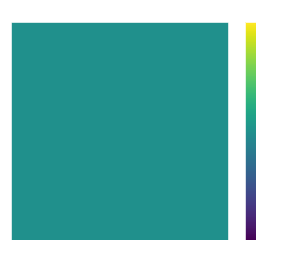

In [2]:
num_photons = 500
num_pixels  = 256
mu_p        = num_photons * np.ones((num_pixels, num_pixels))

fig, ax = plt.subplots()
img = ax.imshow(mu_p, vmin=400, vmax=600)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('No noise')

cb = plt.colorbar(img)
cb.set_label('Photons')

plt.show()

[Photon shot noise](https://en.wikipedia.org/wiki/Shot_noise) arises from the fact that the incident number of photons is not deterministic but rather a random process whose statistics are Poissonian. In a Poisson process, the variance of the noise \\( \sigma_p^2 \\) is equal to the mean number of photons \\( \mu_p \\).

Poisson random numbers are easy to generate with NumPy. First, we set a seed so that we can reproducibly generate the same random numbers each time and initialize a [RandomState](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.RandomState.html#numpy.random.RandomState) instance with it. Using this RandomState instance, we call the `poisson` method with a mean of `num_photons` and a size `(num_pixels, num_pixels)`. Finally, we plot the image and compare it to the one where no shot noise is present.

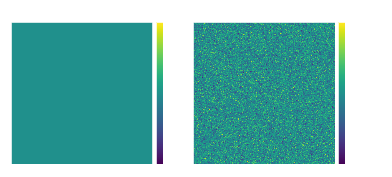

In [3]:
seed       = 42
rs         = np.random.RandomState(seed)
shot_noise = rs.poisson(num_photons, (num_pixels, num_pixels))

fig, (ax0, ax1) = plt.subplots(ncols=2)
img0 = ax0.imshow(mu_p, vmin=400, vmax=600)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('No shot noise')

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = plt.colorbar(img0, cax=cax)
cb0.set_ticks([])

img1 = ax1.imshow(shot_noise, vmin=400, vmax=600)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Shot noise')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(img1, cax=cax)
cb1.set_label('Photons')

plt.show()

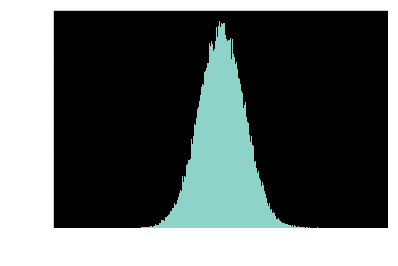

In [4]:
# It's also interesting to look at the distribution of photons hitting each pixel.
plt.hist(shot_noise.ravel(), bins=np.arange(350, 650))
plt.xlabel('Number of photons per pixel')
plt.ylabel('Frequency')
plt.show()

## Step 2: Compute the number of photoelectrons

At this point we're going to need some numbers for our camera. For this example, I chose a camera using the popular Sony IMX264 CMOS chip, the [FLIR Chamleon 3](https://www.ptgrey.com/chameleon3-50-mp-mono-usb3-vision-sonyimx264) (part number CM3-U3-50S5M-CS). Here are some of the key [specs](https://www.ptgrey.com/support/downloads/10430) for our modeling:

<table>
<tr>
  <th>Spec</th>
  <th>Value</th>
</tr>

<tr>
  <td>Quantum efficiency (at 525 nm)</td>
  <td>0.69</td>
</tr>

<tr>
  <td>Sensitivity</td>
  <td>5.88 ADU / e-</td>
</tr>

<tr>
  <td>Temporal dark noise</td>
  <td>2.29 e-</td>
</tr>

<tr>
  <td>Pixel size</td>
  <td>3.45 microns</td>
</tr>

<tr>
  <td>Analog-to-digital converter (ADC)</td>
  <td>12-bit</td>
</tr>
</table>

Assuming our light has a wavelength of 525 nm, then the number of photoelectrons is simply the product of the quantum efficiency with the realization of the field.

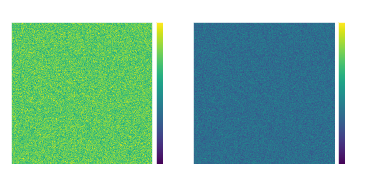

In [5]:
quantum_efficiency = 0.69
# Round the result to ensure that we have a discrete number of electrons
electrons = np.round(quantum_efficiency * shot_noise)

fig, (ax0, ax1) = plt.subplots(ncols=2)
img0 = ax0.imshow(shot_noise, vmin=200, vmax=600)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('Photons')

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = plt.colorbar(img0, cax=cax)
cb0.set_ticks([])

img1 = ax1.imshow(electrons, vmin=200, vmax=600)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Electrons')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(img1, cax=cax)

plt.show()

## Step 3: Simulate read noise and dark current

Following the schematic of the camera model above, we see that we next need to add the dark noise. Dark noise (not to be confused with dark current) refers to the noise in the pixels when there is no light on the camera. Typically we deal with two sources of dark noise: readout (or just "read") noise and dark current. The camera specs in our example only provide us with the total dark noise, which is not surprising since dark current is not very significant in microscopy or machine vision. (It is however significant in astronomy because of the very long exposure times of several seconds or more, which allows appreciable dark current electrons to accumulate during the exposure.)

To the best of my knowledge, when dark noise is primarily read noise we may well model it as a Gaussian distribution whose standard deviation is equivalent to the dark noise spec of the camera. This modeling approach is taken, for example, in the [2016 SMLMS Challenge](http://bigwww.epfl.ch/smlm/challenge2016/index.html?p=methods#4), a community-driven competition to identify the best reconstruction algorithms for single molecule localization microscopy. Please note that the noise model employed in the challenge was for an electron multiplying CCD (EMCCD), so you may find that it differs slightly from what I am discussing here.

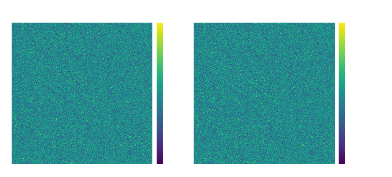

In [6]:
dark_noise = 2.29 # electrons
electrons_out = np.round(rs.normal(scale=dark_noise, size=electrons.shape) + electrons)

fig, (ax0, ax1) = plt.subplots(ncols=2)
img0 = ax0.imshow(electrons, vmin=250, vmax=450)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('Electrons In')

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = plt.colorbar(img0, cax=cax)
cb0.set_ticks([])

img1 = ax1.imshow(electrons_out, vmin=250, vmax=450)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Electrons Out')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(img1, cax=cax)
cb.set_label('Electrons')

plt.show()

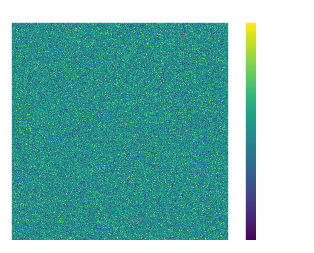

In [7]:
# Plot the difference between the two
fig, ax = plt.subplots()
img = ax.imshow(electrons - electrons_out, vmin=-10, vmax=10)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Difference')

cb = plt.colorbar(img)
cb.set_label('Electrons')

plt.show()

## Step 4: Convert from \\( e^- \\) to ADU

Now we need to convert the value of each pixel from electrons to ADU, or analog-to-digital units. ADU's are the units of grey scale that are output by monochrome cameras. To do this, we multiply the number of electrons after the addition of read noise by the sensitivity. We also need to ensure that the final ADU count is discrete and to set the maximum upper value of ADU's to the \\( 2^k - 1 \\) where \\( k \\) is the camera's bit-depth. The latter operation ensures that saturation of the pixels is correctly modeled.

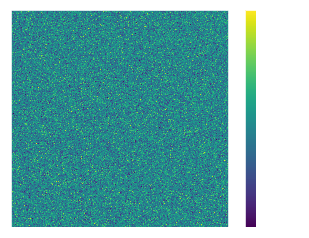

In [8]:
sensitivity = 5.88 # ADU/e-
bitdepth    = 12
max_adu     = np.int(2**bitdepth - 1)
adu         = (electrons_out * sensitivity).astype(np.int)
adu[adu > max_adu] = max_adu # models pixel saturation

fig, ax = plt.subplots()
img = ax.imshow(adu)
ax.set_xticks([])
ax.set_yticks([])

cb = plt.colorbar(img)
cb.set_label('ADU')

plt.show()

## Step 5: Add a basline

Many cameras have a built-in baseline ADU value. This prevents the number of ADU's from becoming negative at low input signal. The [Andor Zyla 4.2](http://www.andor.com/scientific-cameras/neo-and-zyla-scmos-cameras/zyla-42-plus-scmos), for example, has a baseline value of 100 ADU. If you take a large number of dark frames and compute the average of each pixel in a Zyla, the average values will very nearly be 100.

We don't have baseline information for this camera, but 100 seems like a reasonable assumption. Here's what our final image will look like if we had a constant average of 500 photons incident on each pixel.

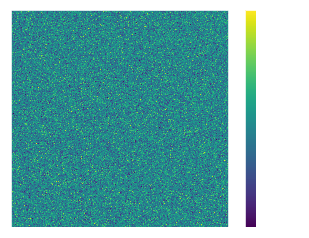

In [9]:
baseline  = 100 # ADU
adu      += baseline

# EDIT: Note that we could have easily just performed this next step once
# here, rather than in the previous step
adu[adu > max_adu] = max_adu


fig, ax = plt.subplots()
img = ax.imshow(adu)
ax.set_xticks([])
ax.set_yticks([])

cb = plt.colorbar(img)
cb.set_label('ADU')

plt.show()

# Adding noise to a simulated hologram

Let's see how the hologram from my last post will look like if I add camera noise to it. I'm going to assume that we are using the same camera as in my example to record the hologram. First, we'll setup the Fourier optics code [as before to make the hologram](simulating-inline-holograms.html). Then, we'll write a function that adds the noise and, in each frame of the animation, call it with the calculated field as an input.

This first part more-or-less repeats the essential bits of my last post. We make a circular object that doesn't absorb any light but which has a refractive index which causes a constant phase shift of 0.75 radians. We then use Fourier optics to compute the scattered field in the same plane as the object; this will be the starting frame of the animation. [Instead of directly computing the number of photons per pixel from the field](#Step-0:-Convert-the-electric-field-to-photons), we simply renormalize it so that the maximum value is 100 photons. 100 photons might seem like a weak signal, but this is actually quite a good camera and we will need to make the signal weak so that we can see the noise in the movie. In fact, the spec sheet for the camera reports an absolute minimum detectable signal of about 4 photons per pixel.

In [10]:
# Ground truth: a circular phase-only object
numPixels = 512
gtRadius  = 50 # ground truth radius, pixels
gtPhase   = 0.75 # radians
gtCenter  = numPixels / 2 # assumes numPixels is even
W, H      = np.meshgrid(np.arange(0, numPixels), np.arange(0, numPixels)) # coordinates of the array indexes
gtMask    = np.sqrt((W - gtCenter)**2 + (H - gtCenter)**2) <= gtRadius # boundaries of the object
gt = np.ones((numPixels, numPixels), dtype=np.complex)
gt[gtMask] = np.exp(1j * gtPhase)

# Physical dimensions and sampling
pixelSize = 0.1 # microns
x = np.linspace(-pixelSize * numPixels / 2, pixelSize * numPixels / 2, num = numPixels, endpoint = True)

dx = x[1] - x[0]    # Sampling period, microns
fS = 1 / dx         # Spatial sampling frequency, inverse microns
df = fS / numPixels # Spacing between discrete frequency coordinates, inverse microns
fx = np.arange(-fS / 2, fS / 2, step = df) # Spatial frequency, inverse microns

# Fourier transform of ground truth
GT = ifftshift(fft2(fftshift(gt))) * dx**2

# Angular spectrum propagator and spatial frequencies
def H(fx, fy, z, wavelength=0.5):
    square_root = np.sqrt(1 - (wavelength**2 * fx**2) - (wavelength**2 * fy**2))
    temp = exp(1j * 2 * np.pi * z / wavelength * square_root)
    temp[np.isnan(temp)] = 0 # replace nan's with zeros
    return temp

FX, FY = np.meshgrid(fx, fx)

# Field at a distance of z=0
gt_prime = fftshift(ifft2(ifftshift(GT))) / dx**2

# Normalizing constant: makes the maximum photon count at z = 0 equal to 100 photons
norm = np.max(np.abs(gt_prime)**2) / 100

Next we create a Python function which takes as input a map of photons per pixel from our Fourier optics calculations and our camera specs. Since it doesn't have a large effect, I am skipping the explicit rounding of continuous numbers at each step and saving it until the end when the ADU's are calculated. I also added a random number generator to the inputs in case you want to reproduce previous results, but this isn't too important for this post.

In [11]:
# Function to add camera noise
def add_camera_noise(input_irrad_photons, qe=0.69, sensitivity=5.88,
                     dark_noise=2.29, bitdepth=12, baseline=100,
                     rs=np.random.RandomState(seed=42)):
 
    # Add shot noise
    photons = rs.poisson(input_irrad_photons, size=input_irrad_photons.shape)
    
    # Convert to electrons
    electrons = qe * photons
    
    # Add dark noise
    electrons_out = rs.normal(scale=dark_noise, size=electrons.shape) + electrons
    
    # Convert to ADU and add baseline
    max_adu     = np.int(2**bitdepth - 1)
    adu         = (electrons_out * sensitivity).astype(np.int) # Convert to discrete numbers
    adu += baseline
    adu[adu > max_adu] = max_adu # models pixel saturation
    
    return adu

Finally, we create our animation of the simulated digital images of an inline planewave hologram from the object at axial planes between \\( 0 \\) and \\( 100 \, \mu m \\) away from the object. It's true that some of the noise you will see in the video is due to the compression artifacts, but a lot of it is also due to the temporal noise in each individual pixel. Pay close to attention the regions of low signal to see it.

In [12]:
# Create the animation as before, this time add camera noise
numPoints = 100
z         = np.linspace(0, 100, num = numPoints)

fig, ax    = plt.subplots(nrows=1, ncols=1)
vmin, vmax = 0, 1500

img = ax.imshow(np.abs(gt_prime)**2 / norm, vmin=vmin, vmax=vmax)
img.set_extent([x[0], x[-1], x[0], x[-1]])
ax.set_xticks([x[0], x[-1]])
ax.set_yticks([x[0], x[-1]])
ax.set_xlabel(r'$x, \, \mu m$')

cb  = plt.colorbar(img)
cb.set_label('ADU')
cb.set_clim([vmin, vmax])

txt = ax.text(8, 20, 'z = {:.1f} $\mu m$'.format(0))

# Initialize the figure with an empty frame
def init():
    img.set_data(np.zeros((numPixels, numPixels)))
    return img,

# This function is called for each frame of the animation
def animate(frame):
    gt_prime = fftshift(ifft2(ifftshift(GT * H(FX, FY, z[frame], wavelength=0.525)))) / dx**2
    
    # Divide by norm to convert to a photons
    hologram = np.abs(gt_prime)**2 / norm
    
    # NEW: Add camera noise
    adu = add_camera_noise(hologram)
    
    img.set_data(adu)
    img.set_extent([x[0], x[-1], x[0], x[-1]])

    txt.set_text('z = {:.1f} $\mu m$'.format(z[frame]))
    return img,

# Create the animation
anim = animation.FuncAnimation(fig, animate, frames=numPoints,
                               init_func=init, interval=20, blit=True)

# Save the animation
myWriter = animation.FFMpegWriter(fps=10, extra_args=['-vcodec', 'libx264'])
anim.save('propagating_hologram_with_noise.mp4', writer = myWriter)
    
plt.close()

/home/kmdouglass/venvs/nikola/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


<video controls src="/propagating_hologram_with_noise.mp4" type="video/mp4" />

# Simulated holograms on a poor camera

As I mentioned, the FLIR Chameleon camera is actually quite good. In fact, a similar camera with the Sony IMX265 chip has been successfully used for [single molecule localization microscopy](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5431525/), which means that the noise floor is low enough and the quantum efficiency is high enough to detect the fluorescence from single molecules. Here's what another hologram might look like if the dark noise was worse, say 20 electrons. (For comparison, many sensors in digital cameras have read noise values around or below 10 electrons. Thanks [@kD3AN](https://twitter.com/kD3AN/status/885602631091179521) for this [link](http://www.clarkvision.com/articles/digital.sensor.performance.summary/#read_noise).)

Notice how many of the features of the hologram--especially those away from the center--become much more difficult to detect due to increased dark noise of the sensor. In particular, try pausing both movies around a distance of \\( 40 \, \mu m \\) and notice how much clearer the rings are for the low noise camera.

In [13]:
# Create the animation as before, this time add camera noise
numPoints = 100
z         = np.linspace(0, 100, num = numPoints)

fig, ax    = plt.subplots(nrows=1, ncols=1)
vmin, vmax = 0, 1500

img = ax.imshow(np.abs(gt_prime)**2 / norm, vmin=vmin, vmax=vmax)
img.set_extent([x[0], x[-1], x[0], x[-1]])
ax.set_xticks([x[0], x[-1]])
ax.set_yticks([x[0], x[-1]])
ax.set_xlabel(r'$x, \, \mu m$')

cb  = plt.colorbar(img)
cb.set_label('ADU')
cb.set_clim([vmin, vmax])

txt = ax.text(8, 20, 'z = {:.1f} $\mu m$'.format(0))

# Initialize the figure with an empty frame
def init():
    img.set_data(np.zeros((numPixels, numPixels)))
    return img,

# This function is called for each frame of the animation
def animate(frame):
    gt_prime = fftshift(ifft2(ifftshift(GT * H(FX, FY, z[frame], wavelength=0.525)))) / dx**2
    
    # Divide by norm to convert to a preset number of photons
    hologram = np.abs(gt_prime)**2 / norm
    
    # NEW: Add camera noise
    adu = add_camera_noise(hologram, dark_noise=20)
    
    img.set_data(adu)
    img.set_extent([x[0], x[-1], x[0], x[-1]])

    txt.set_text('z = {:.1f} $\mu m$'.format(z[frame]))
    return img,

# Create the animation
anim = animation.FuncAnimation(fig, animate, frames=numPoints,
                               init_func=init, interval=20, blit=True)

# Save the animation
myWriter = animation.FFMpegWriter(fps=10, extra_args=['-vcodec', 'libx264'])
anim.save('propagating_hologram_with_noise_poor.mp4', writer = myWriter)
    
plt.close()

/home/kmdouglass/venvs/nikola/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


<video controls src="/propagating_hologram_with_noise_poor.mp4" type="video/mp4" />

# Discussion

The addition of realistic camera noise to the hologram simulations is an important part of the simulation framework. It's impossible to record a digital hologram without noise, so any good holographic reconstruction algorithm needs to be capable of making estimates of the original object in the presence of shot noise and noise from the camera.

One source of noise that we did not model was noise associated with pixel non-uniformities. This sort of effect represents a pixel-dependent sensitivity, quantum efficiency, and dark noise. Non-uniformities are very often important take into account in image analysis but difficult to both measure and model. They're difficult to measure because you need a **very** stable light source that is **very** flat to a degree that is better than 99% across the camera chip. Believe me when I say that creating such a flat illumination pattern is extremely difficult, even with incoherent light. (The way to do it is to use an [integrating sphere](https://en.wikipedia.org/wiki/Integrating_sphere) that directly faces the camera chip. The f-number of exit port of the sphere is recommended to be F/# = 8 in the EMVA 1288 standard.) They're difficult to model because they cannot be represented by a single number the way, for example, dark noise or quantum efficiency can.

The type of noise we modeled is called temporal noise because it deals with pixel-to-pixel variations in the output of the grey values. This is an important but often over-looked distinction when discussing camera noise.

Finally, the code I developed above should serve as a great tool to help you test cameras before you buy them. Most manufacturers will provide all the numbers used in the model on their websites, especially if they follow the EMVA 1288 Standard. Look up the numbers, plug them into the `add_camera_noise` function, and simulate a few frames to get a rough idea of how your images are going to look.